In [1]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 

## 데이터 불러오기

In [12]:
DATA_PATH =  "../[01]Data/"
datas = os.listdir(DATA_PATH)
print('CoREMOF_O2_15.0_5760.csv')
O2_15bar = pd.read_csv(os.path.join(DATA_PATH , 'CoREMOF_O2_15.0_5760.csv')).reset_index(drop = True).drop("Unnamed: 0", axis = 1)
O2_15bar  = O2_15bar[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
       'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g', 'Has_OMS',
       '0.5bar_GCMC',  'Uptake']]

CoREMOF_O2_15.0_5760.csv


Index(['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
       'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g', 'Has_OMS',
       '0.5bar_GCMC', 'Uptake'],
      dtype='object')

## 액티브 러닝 몬테카를로 드랍아웃
* 10개씩 추가 샘플링해가며 5%부터 학습

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Monte Carlo Dropout 예측 함수
def mc_dropout_predict(model, X, n_simulations):
    model.train()  # 드롭아웃 활성화를 위해 train 모드 유지
    predictions = []
    with torch.no_grad():  # 가중치 업데이트 방지
        for _ in range(n_simulations):
            predictions.append(model(X).detach().numpy())
    
    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)
    uncertainty = predictions.std(axis=0)
    return mean_prediction, uncertainty

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_1.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
# 'NASA_m2_cm3', 'NASA_m2_g', 'NAV_cm3_g' 제거

X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))  # 데이터셋 인덱스를 랜덤으로 섞음
initial_indices = indices[:initial_size]  # 상위 5% 인덱스 선택
remaining_indices = indices[initial_size:]  # 나머지 인덱스 선택

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices]
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns)
y_remaining = y_train.iloc[remaining_indices]
def create_dataloader(X, y, batch_size=32, shuffle=True):
    # y를 numpy 배열로 변환 (필요 시)
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

input_dim = X_train.shape[1]
hidden_dim = 64
# StandardScaler를 초기 데이터에 대해 피팅
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)

# 남은 데이터를 그대로 둠 (추후 transform 적용)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns)
y_remaining = y_train.iloc[remaining_indices].to_numpy()

# 초기 데이터 로더 생성
train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
model = DropoutMLP(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 초기 학습
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# 액티브 러닝 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

# 초기 성능 평가
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
mse = mean_squared_error(y_test, mean_prediction)
r2 = r2_score(y_test, mean_prediction)
performance_log.append((mse, r2))
print(f"Initial Test MSE: {mse}, R2: {r2}")

# 반복 학습
for iteration in range(iterations):
    # Monte Carlo Dropout 예측
    _, uncertainties = mc_dropout_predict(model, torch.tensor(scaler.transform(X_remaining), dtype=torch.float32), n_simulations=20)
    uncertainties = uncertainties.flatten()

    # 가장 불확실성이 높은 샘플 선택
    most_uncertain_indices = np.argsort(uncertainties)[-samples_per_iteration:]
    sampled_X = X_remaining.iloc[most_uncertain_indices].values
    sampled_y = y_remaining[most_uncertain_indices]

    # 선택된 샘플 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])

    # 남은 데이터에서 샘플 제거
    X_remaining = X_remaining.drop(X_remaining.index[most_uncertain_indices]).reset_index(drop=True)
    y_remaining = np.delete(y_remaining, most_uncertain_indices, axis=0)

    # 새 데이터 스케일링 및 로더 생성
    X_initial_scaled = scaler.transform(X_initial)
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 모델 학습
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
    mse = mean_squared_error(y_test, mean_prediction)
    r2 = r2_score(y_test, mean_prediction)
    performance_log.append((mse, r2))
    print(f"Iteration {iteration + 1}/{iterations} - Test MSE: {mse}, R2: {r2}")

# 최종 성능 기록
print("Performance log:", performance_log)
first_log = performance_log


Initial Test MSE: 0.0043948672362705485, R2: 0.9188898596574582


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 1/100 - Test MSE: 0.003532801785872044, R2: 0.9347998396198142


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 2/100 - Test MSE: 0.0024243527735363906, R2: 0.9552569888622542


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 3/100 - Test MSE: 0.0011302226114888144, R2: 0.979141004788585


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 4/100 - Test MSE: 0.0009334162531163232, R2: 0.9827731944520534


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 5/100 - Test MSE: 0.0007043290445403077, R2: 0.9870011482534632


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 6/100 - Test MSE: 0.0007963323116269829, R2: 0.985303167972333


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 7/100 - Test MSE: 0.0007055709797777525, R2: 0.9869782275289021


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 8/100 - Test MSE: 0.0009633355454724881, R2: 0.9822210144039439


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 9/100 - Test MSE: 0.0008185031127564246, R2: 0.9848939913819063


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 10/100 - Test MSE: 0.0007397140778664613, R2: 0.9863480943920352


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 11/100 - Test MSE: 0.0010356377534602168, R2: 0.9808866300137714


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 12/100 - Test MSE: 0.0007291366129294039, R2: 0.986543308404061


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 13/100 - Test MSE: 0.0008070123850581018, R2: 0.9851060602536476


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 14/100 - Test MSE: 0.001186269360823243, R2: 0.9781066254865799


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 15/100 - Test MSE: 0.0012940763081526498, R2: 0.9761169779824133


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 16/100 - Test MSE: 0.0010872297360825511, R2: 0.9799344663359901


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 17/100 - Test MSE: 0.001024398909154943, R2: 0.9810940502132636


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 18/100 - Test MSE: 0.0008750848280026351, R2: 0.983849738935196


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 19/100 - Test MSE: 0.0008698224770136297, R2: 0.9839468590538033


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 20/100 - Test MSE: 0.0010055384675446265, R2: 0.9814421319603776


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 21/100 - Test MSE: 0.0007021886899995521, R2: 0.9870406498920453


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 22/100 - Test MSE: 0.0009535050579558592, R2: 0.982402442460639


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 23/100 - Test MSE: 0.0008243102916248242, R2: 0.9847868161095514


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 24/100 - Test MSE: 0.001080089822489511, R2: 0.9800662380966444


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 25/100 - Test MSE: 0.0012497350457421747, R2: 0.976935324891143


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 26/100 - Test MSE: 0.0007509411382798945, R2: 0.9861408916719502


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 27/100 - Test MSE: 0.0009671945325276008, R2: 0.9821497942817439


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 28/100 - Test MSE: 0.0008703681742713445, R2: 0.9839367878551122


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 29/100 - Test MSE: 0.0009100791356160153, R2: 0.9832038961715543


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 30/100 - Test MSE: 0.0010065765232610444, R2: 0.9814229739653084


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 31/100 - Test MSE: 0.0008828080604599989, R2: 0.9837072016445709


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 32/100 - Test MSE: 0.0018387822863948147, R2: 0.9660640740002363


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 33/100 - Test MSE: 0.0009245404490686238, R2: 0.9829370032028661


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 34/100 - Test MSE: 0.0012390029853880692, R2: 0.9771333920623881


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 35/100 - Test MSE: 0.0010171782980895531, R2: 0.9812273112983856


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 36/100 - Test MSE: 0.0007875690072555074, R2: 0.9854649004682702


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 37/100 - Test MSE: 0.0007974278766216527, R2: 0.985282948606037


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 38/100 - Test MSE: 0.0011554362594969525, R2: 0.9786756704750454


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 39/100 - Test MSE: 0.0006565413194386105, R2: 0.9878831018782873


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 40/100 - Test MSE: 0.0009148569172062822, R2: 0.9831157190971448


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 41/100 - Test MSE: 0.0007522252902887347, R2: 0.9861171918093472


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 42/100 - Test MSE: 0.0009214415026379801, R2: 0.9829941962797876


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 43/100 - Test MSE: 0.0006665098835711787, R2: 0.9876991255276177


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 44/100 - Test MSE: 0.0009504487481745539, R2: 0.9824588486503975


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 45/100 - Test MSE: 0.0008385131888069056, R2: 0.9845246923816259


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 46/100 - Test MSE: 0.0008735531911837706, R2: 0.9838780062913306


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 47/100 - Test MSE: 0.0006494259902803113, R2: 0.9880144199171691


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 48/100 - Test MSE: 0.0006173031244014242, R2: 0.9886072683513921


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 49/100 - Test MSE: 0.0009229254257734973, R2: 0.982966809510789


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 50/100 - Test MSE: 0.0007774921222415466, R2: 0.9856508759514322


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 51/100 - Test MSE: 0.0009664036360272567, R2: 0.9821643907923302


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 52/100 - Test MSE: 0.0007710023284220235, R2: 0.9857706493277816


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 53/100 - Test MSE: 0.0006537481483485147, R2: 0.9879346516719304


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 54/100 - Test MSE: 0.0007503398217182295, R2: 0.9861519893611601


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 55/100 - Test MSE: 0.0008181871998749395, R2: 0.9848998217601124


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 56/100 - Test MSE: 0.0014905646814287758, R2: 0.9724906569412278


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 57/100 - Test MSE: 0.0005021731339242165, R2: 0.9907320673915484


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 58/100 - Test MSE: 0.000771731707636021, R2: 0.9857571881588247


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 59/100 - Test MSE: 0.0010273641099106435, R2: 0.9810393254999767


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 60/100 - Test MSE: 0.0006986012277834947, R2: 0.9871068588463037


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 61/100 - Test MSE: 0.0012885964426395738, R2: 0.976218112473384


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 62/100 - Test MSE: 0.0006075546750738139, R2: 0.9887871823398192


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 63/100 - Test MSE: 0.0005266008114036695, R2: 0.9902812386765764


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 64/100 - Test MSE: 0.0007087871935615034, R2: 0.9869188702065195


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 65/100 - Test MSE: 0.0007269111434637495, R2: 0.9865843808940779


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 66/100 - Test MSE: 0.0008762801575580094, R2: 0.9838276783488848


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 67/100 - Test MSE: 0.0007518787427884708, R2: 0.986123587569417


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 68/100 - Test MSE: 0.0006942090957627341, R2: 0.9871879185064606


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 69/100 - Test MSE: 0.0009386402695886101, R2: 0.9826767818219465


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 70/100 - Test MSE: 0.0004587368343500525, R2: 0.9915337126210891


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 71/100 - Test MSE: 0.000852032821100126, R2: 0.9842751787527197


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 72/100 - Test MSE: 0.0005241228215451902, R2: 0.9903269715950886


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 73/100 - Test MSE: 0.0006189647340813191, R2: 0.9885766022613637


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 74/100 - Test MSE: 0.0006208900484452185, R2: 0.9885410693294537


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 75/100 - Test MSE: 0.000840564170764244, R2: 0.9844868401723426


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 76/100 - Test MSE: 0.0006554811301147176, R2: 0.9879026683635137


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 77/100 - Test MSE: 0.0004670174113028692, R2: 0.9913808891744064


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 78/100 - Test MSE: 0.0012549418777688596, R2: 0.9768392294111842


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 79/100 - Test MSE: 0.00032809751965768544, R2: 0.9939447463518699


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 80/100 - Test MSE: 0.0008632353820916542, R2: 0.9840684281854398


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 81/100 - Test MSE: 0.000569829777754557, R2: 0.9894834199168545


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 82/100 - Test MSE: 0.0005670091992359458, R2: 0.9895354755324607


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 83/100 - Test MSE: 0.0009669251631176886, R2: 0.9821547656698354


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 84/100 - Test MSE: 0.0008244651427772176, R2: 0.9847839582305695


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 85/100 - Test MSE: 0.0005739352542331603, R2: 0.9894076506716304


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 86/100 - Test MSE: 0.0007334758920668473, R2: 0.9864632241783263


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 87/100 - Test MSE: 0.000665623903280445, R2: 0.9877154768715513


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 88/100 - Test MSE: 0.0008779495099051218, R2: 0.9837968693628846


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 89/100 - Test MSE: 0.0005511960923013601, R2: 0.9898273167312416


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 90/100 - Test MSE: 0.0007137072152882316, R2: 0.9868280679976497


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 91/100 - Test MSE: 0.0008700975224367744, R2: 0.9839417829111868


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 92/100 - Test MSE: 0.0003886405120656297, R2: 0.9928273859523478


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 93/100 - Test MSE: 0.0005579890252690575, R2: 0.9897019487242629


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 94/100 - Test MSE: 0.0007625342497304521, R2: 0.9859269332413061


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 95/100 - Test MSE: 0.0007839609118669051, R2: 0.985531490221181


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 96/100 - Test MSE: 0.0011504778939762472, R2: 0.9787671803436337


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 97/100 - Test MSE: 0.0006669070377680079, R2: 0.9876917957879667


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 98/100 - Test MSE: 0.0006307900391354968, R2: 0.9883583585463722


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 99/100 - Test MSE: 0.000653007859862892, R2: 0.987948314178608


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100/100 - Test MSE: 0.0006672700446552003, R2: 0.9876850962591796
Performance log: [(0.0043948672362705485, 0.9188898596574582), (0.003532801785872044, 0.9347998396198142), (0.0024243527735363906, 0.9552569888622542), (0.0011302226114888144, 0.979141004788585), (0.0009334162531163232, 0.9827731944520534), (0.0007043290445403077, 0.9870011482534632), (0.0007963323116269829, 0.985303167972333), (0.0007055709797777525, 0.9869782275289021), (0.0009633355454724881, 0.9822210144039439), (0.0008185031127564246, 0.9848939913819063), (0.0007397140778664613, 0.9863480943920352), (0.0010356377534602168, 0.9808866300137714), (0.0007291366129294039, 0.986543308404061), (0.0008070123850581018, 0.9851060602536476), (0.001186269360823243, 0.9781066254865799), (0.0012940763081526498, 0.9761169779824133), (0.0010872297360825511, 0.9799344663359901), (0.001024398909154943, 0.9810940502132636), (0.0008750848280026351, 0.983849738935196), (0.0008698224770136297, 0.9839468590538033), (0.0010055384

## 랜덤하게 샘플링해서 추가

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_1.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))
initial_indices = indices[:initial_size]
remaining_indices = indices[initial_size:]

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices].to_numpy()

# 스탠다드 스케일러 적용
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop =True)
y_remaining = y_train.iloc[remaining_indices].reset_index(drop =True)

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
input_dim = X_train.shape[1]
hidden_dim = 64
model = DropoutMLP(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 초기 모델 학습
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# 랜덤 샘플링 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

X_remaining_tensor = torch.tensor(X_remaining.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# 초기 Test 성능 평가
mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
mse = mean_squared_error(y_test, mean_prediction)
r2 = r2_score(y_test, mean_prediction)
performance_log.append((mse, r2))
print(f"Initial Test MSE: {mse}, R2: {r2}")

for iteration in range(iterations):
    # 랜덤으로 샘플 선택
    sample_indices = np.random.choice(X_remaining.index, size=samples_per_iteration, replace=False)
    sample_indices = X_remaining.index[sample_indices]  # 현재 인덱스 동기화
    sampled_X = X_remaining.iloc[sample_indices].values
    sampled_y = y_remaining.iloc[sample_indices].to_numpy()

    # 선택된 샘플을 Training Set에 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])
    X_initial_scaled = scaler.transform(X_initial)
    # 남은 데이터에서 선택된 샘플 제거
    X_remaining = X_remaining.drop(sample_indices).reset_index(drop=True)  # 인덱스 초기화
    y_remaining = y_remaining.drop(sample_indices).reset_index(drop=True)  # 인덱스 초기화


    # 새 학습 데이터로 DataLoader 생성
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 모델 재학습
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
    mse = mean_squared_error(y_test, mean_prediction)
    r2 = r2_score(y_test, mean_prediction)
    performance_log.append((mse, r2))
    print(f"Iteration {iteration + 1}/{iterations} - Test MSE: {mse}, R2: {r2}")

# 성능 기록 출력
print("Performance log:", performance_log)
second_log = performance_log


Initial Test MSE: 0.008600090682369381, R2: 0.8412797191121735


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 1/100 - Test MSE: 0.004697864732747438, R2: 0.9132978433025944


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 2/100 - Test MSE: 0.003087368958073112, R2: 0.9430205928834794


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 3/100 - Test MSE: 0.002023969861346189, R2: 0.9626463165603671


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 4/100 - Test MSE: 0.002104367325180649, R2: 0.9611625289453557


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 5/100 - Test MSE: 0.003196440852458628, R2: 0.9410075999566342


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 6/100 - Test MSE: 0.002964316693802769, R2: 0.9452916026518893


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 7/100 - Test MSE: 0.0029827698960172167, R2: 0.9449510367733502


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 8/100 - Test MSE: 0.0028852178319286326, R2: 0.9467514237210215


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 9/100 - Test MSE: 0.00211791180625744, R2: 0.9609125567159471


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 10/100 - Test MSE: 0.0030617394732665483, R2: 0.9434936017362636


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 11/100 - Test MSE: 0.0024739544886805656, R2: 0.9543415568684566


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 12/100 - Test MSE: 0.003253567907856596, R2: 0.9399532829018562


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 13/100 - Test MSE: 0.003489399342445949, R2: 0.9356008600120677


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 14/100 - Test MSE: 0.0017582191079622957, R2: 0.9675509199862024


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 15/100 - Test MSE: 0.0029285086056303287, R2: 0.9459524642663415


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 16/100 - Test MSE: 0.0030864935808773506, R2: 0.9430367485403818


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 17/100 - Test MSE: 0.002321654937534797, R2: 0.9571523443856745


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 18/100 - Test MSE: 0.002977633494669014, R2: 0.945045832409216


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 19/100 - Test MSE: 0.00258756838071023, R2: 0.9522447384136611


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 20/100 - Test MSE: 0.00623341401927332, R2: 0.8849582800263451


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 21/100 - Test MSE: 0.0037487188159671956, R2: 0.930814950049356


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 22/100 - Test MSE: 0.003394011282472778, R2: 0.9373613088528369


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 23/100 - Test MSE: 0.0022663787320503707, R2: 0.9581725027985256


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 24/100 - Test MSE: 0.002369752688814252, R2: 0.9562646690255998


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 25/100 - Test MSE: 0.002291687104954686, R2: 0.9577054202752655


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 26/100 - Test MSE: 0.0023596497341437316, R2: 0.9564511256412712


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 27/100 - Test MSE: 0.006643839524014335, R2: 0.8773836097348366


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 28/100 - Test MSE: 0.003113272660333991, R2: 0.9425425231687833


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 29/100 - Test MSE: 0.0024512276195920745, R2: 0.9547609960556295


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 30/100 - Test MSE: 0.005603814843879836, R2: 0.896577943313159


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 31/100 - Test MSE: 0.001820207530146759, R2: 0.9664068832377201


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 32/100 - Test MSE: 0.001455990134807363, R2: 0.9731287527420744


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 33/100 - Test MSE: 0.002668037763157763, R2: 0.9507596234937538


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 34/100 - Test MSE: 0.0014877306551981306, R2: 0.9725429607431277


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 35/100 - Test MSE: 0.0037682647516005066, R2: 0.9304542170630987


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 36/100 - Test MSE: 0.004742638311412775, R2: 0.9124715177155068


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 37/100 - Test MSE: 0.0012515199944109611, R2: 0.9769023824996562


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 38/100 - Test MSE: 0.0011738024043389886, R2: 0.9783367112970764


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 39/100 - Test MSE: 0.005022205389468643, R2: 0.9073119250094691


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 40/100 - Test MSE: 0.002798002224042138, R2: 0.9483610446300109


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 41/100 - Test MSE: 0.007983548192816166, R2: 0.8526584127487161


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 42/100 - Test MSE: 0.0014886701128854981, R2: 0.9725256224389716


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 43/100 - Test MSE: 0.0013842908872084877, R2: 0.9744520091051346


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 44/100 - Test MSE: 0.0010891323429176904, R2: 0.9798993524863291


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 45/100 - Test MSE: 0.0032881057411909003, R2: 0.9393158646686606


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 46/100 - Test MSE: 0.003986503741905326, R2: 0.92642647420303


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 47/100 - Test MSE: 0.0011238803495570186, R2: 0.9792580553677542


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 48/100 - Test MSE: 0.0015848359739714173, R2: 0.9707508187715327


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 49/100 - Test MSE: 0.001602807123067543, R2: 0.9704191494975957


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 50/100 - Test MSE: 0.0014567148026162302, R2: 0.9731153785251713


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 51/100 - Test MSE: 0.0030316715072638955, R2: 0.9440485256534557


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 52/100 - Test MSE: 0.0014841814966986965, R2: 0.9726084627773215


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 53/100 - Test MSE: 0.002097156748450239, R2: 0.9612956048402832


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 54/100 - Test MSE: 0.0037404952245617515, R2: 0.9309667217906069


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 55/100 - Test MSE: 0.0008686800896903051, R2: 0.9839679425567032


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 56/100 - Test MSE: 0.002533388846537478, R2: 0.9532446570424146


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 57/100 - Test MSE: 0.0011636293689678996, R2: 0.9785244612977703


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 58/100 - Test MSE: 0.008096254403167517, R2: 0.8505783461511114


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 59/100 - Test MSE: 0.0009986552042417461, R2: 0.9815691670725883


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 60/100 - Test MSE: 0.002255477405261128, R2: 0.9583736938921946


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 61/100 - Test MSE: 0.0012463258199826369, R2: 0.9769982443753843


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 62/100 - Test MSE: 0.0011307357323272378, R2: 0.979131534808952


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 63/100 - Test MSE: 0.0017007063365183273, R2: 0.9686123556821001


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 64/100 - Test MSE: 0.0030824369037714835, R2: 0.9431116171613644


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 65/100 - Test MSE: 0.0017505420272575848, R2: 0.9676926055161409


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 66/100 - Test MSE: 0.0011482924661518352, R2: 0.978807513839054


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 67/100 - Test MSE: 0.0027798554171063116, R2: 0.9486959557839103


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 68/100 - Test MSE: 0.0058933246812881, R2: 0.8912348505004948


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 69/100 - Test MSE: 0.0018394950144902205, R2: 0.9660509201385298


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 70/100 - Test MSE: 0.0033587388869254927, R2: 0.9380122839106149


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 71/100 - Test MSE: 0.0015695501816031462, R2: 0.9710329280361778


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 72/100 - Test MSE: 0.0016348046621163037, R2: 0.9698286140517369


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 73/100 - Test MSE: 0.002367749556255882, R2: 0.9563016381430269


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 74/100 - Test MSE: 0.0020738333069321366, R2: 0.9617260541606157


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 75/100 - Test MSE: 0.0017671555649501332, R2: 0.967385991845833


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 76/100 - Test MSE: 0.0017223057698177056, R2: 0.9682137240575146


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 77/100 - Test MSE: 0.004024867917442881, R2: 0.9257184383296603


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 78/100 - Test MSE: 0.002463559554299228, R2: 0.9545334021600649


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 79/100 - Test MSE: 0.0014073013940687183, R2: 0.9740273351979496


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 80/100 - Test MSE: 0.0020138533830320205, R2: 0.9628330227636996


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 81/100 - Test MSE: 0.0021274016957613545, R2: 0.9607374146176499


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 82/100 - Test MSE: 0.0017332146244436054, R2: 0.9680123940327119


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 83/100 - Test MSE: 0.0029981590727707653, R2: 0.9446670194824671


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 84/100 - Test MSE: 0.0033537494613364587, R2: 0.9381043670130156


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 85/100 - Test MSE: 0.0013137603830574262, R2: 0.9757536955458329


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 86/100 - Test MSE: 0.0014032966056450452, R2: 0.9741012461794704


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 87/100 - Test MSE: 0.003314609304036852, R2: 0.9388267241357519


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 88/100 - Test MSE: 0.0037437531019265616, R2: 0.9309065955396709


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 89/100 - Test MSE: 0.001397007864441228, R2: 0.9742173089987087


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 90/100 - Test MSE: 0.0023109226143327105, R2: 0.9573504164079506


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 91/100 - Test MSE: 0.0012406602318717965, R2: 0.9771028064979898


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 92/100 - Test MSE: 0.0013887295348149738, R2: 0.9743700909695145


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 93/100 - Test MSE: 0.0015747124456649683, R2: 0.9709376550870693


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 94/100 - Test MSE: 0.0016264282883258288, R2: 0.9699832054915192


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 95/100 - Test MSE: 0.001625334354007554, R2: 0.970003394762619


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 96/100 - Test MSE: 0.002121823129314498, R2: 0.9608403706987075


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 97/100 - Test MSE: 0.0016457391927039973, R2: 0.9696268101603183


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 98/100 - Test MSE: 0.004741717877447707, R2: 0.9124885049244643


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 99/100 - Test MSE: 0.003769191107466149, R2: 0.9304371205616051


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100/100 - Test MSE: 0.0013625593374175084, R2: 0.9748530790257138
Performance log: [(0.008600090682369381, 0.8412797191121735), (0.004697864732747438, 0.9132978433025944), (0.003087368958073112, 0.9430205928834794), (0.002023969861346189, 0.9626463165603671), (0.002104367325180649, 0.9611625289453557), (0.003196440852458628, 0.9410075999566342), (0.002964316693802769, 0.9452916026518893), (0.0029827698960172167, 0.9449510367733502), (0.0028852178319286326, 0.9467514237210215), (0.00211791180625744, 0.9609125567159471), (0.0030617394732665483, 0.9434936017362636), (0.0024739544886805656, 0.9543415568684566), (0.003253567907856596, 0.9399532829018562), (0.003489399342445949, 0.9356008600120677), (0.0017582191079622957, 0.9675509199862024), (0.0029285086056303287, 0.9459524642663415), (0.0030864935808773506, 0.9430367485403818), (0.002321654937534797, 0.9571523443856745), (0.002977633494669014, 0.945045832409216), (0.00258756838071023, 0.9522447384136611), (0.00623341401927332, 

## 랜덤 샘플링이면서 매번 아예 새로운 모델을 학습시키는 코드

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_1.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))
initial_indices = indices[:initial_size]
remaining_indices = indices[initial_size:]

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices].to_numpy()

# 스탠다드 스케일러 적용
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop=True)
y_remaining = y_train.iloc[remaining_indices].reset_index(drop=True)

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
input_dim = X_train.shape[1]
hidden_dim = 64
criterion = nn.MSELoss()

# 랜덤 샘플링 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

for iteration in range(iterations):
    # 랜덤으로 샘플 선택
    sample_indices = np.random.choice(X_remaining.index, size=samples_per_iteration, replace=False)
    sampled_X = X_remaining.iloc[sample_indices].values
    sampled_y = y_remaining.iloc[sample_indices].to_numpy()

    # 선택된 샘플을 Training Set에 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])

    # 남은 데이터에서 선택된 샘플 제거
    X_remaining = X_remaining.drop(sample_indices).reset_index(drop=True)
    y_remaining = y_remaining.drop(sample_indices).reset_index(drop=True)

    # 새 데이터 스케일링
    scaler = StandardScaler()
    X_initial_scaled = scaler.fit_transform(X_initial)
    X_test_scaled = scaler.transform(X_test)
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 새로운 모델 생성
    model = DropoutMLP(input_dim, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 모델 학습
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    performance_log.append((mse, r2))

    print(f"Iteration {iteration + 1}/{iterations} - Samples: {len(y_initial)}, Test MSE: {mse:.4f}, R2: {r2:.4f}")

# 성능 기록 출력
print("Performance log:")
for entry in performance_log:
    print(f"MSE: {entry[0]:.4f}, R2: {entry[1]:.4f}")
third_log = performance_log

c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 1/100 - Samples: 240, Test MSE: 0.0149, R2: 0.7245


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 2/100 - Samples: 250, Test MSE: 0.0044, R2: 0.9188


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 3/100 - Samples: 260, Test MSE: 0.0083, R2: 0.8476


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 4/100 - Samples: 270, Test MSE: 0.0114, R2: 0.7905


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 5/100 - Samples: 280, Test MSE: 0.0089, R2: 0.8366


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 6/100 - Samples: 290, Test MSE: 0.0092, R2: 0.8311


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 7/100 - Samples: 300, Test MSE: 0.0062, R2: 0.8851


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 8/100 - Samples: 310, Test MSE: 0.0066, R2: 0.8790


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 9/100 - Samples: 320, Test MSE: 0.0063, R2: 0.8842


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 10/100 - Samples: 330, Test MSE: 0.0046, R2: 0.9159


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 11/100 - Samples: 340, Test MSE: 0.0047, R2: 0.9139


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 12/100 - Samples: 350, Test MSE: 0.0080, R2: 0.8525


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 13/100 - Samples: 360, Test MSE: 0.0064, R2: 0.8827


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 14/100 - Samples: 370, Test MSE: 0.0036, R2: 0.9341


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 15/100 - Samples: 380, Test MSE: 0.0053, R2: 0.9023


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 16/100 - Samples: 390, Test MSE: 0.0057, R2: 0.8950


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 17/100 - Samples: 400, Test MSE: 0.0070, R2: 0.8706


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 18/100 - Samples: 410, Test MSE: 0.0073, R2: 0.8657


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 19/100 - Samples: 420, Test MSE: 0.0071, R2: 0.8683


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 20/100 - Samples: 430, Test MSE: 0.0107, R2: 0.8024


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 21/100 - Samples: 440, Test MSE: 0.0030, R2: 0.9446


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 22/100 - Samples: 450, Test MSE: 0.0070, R2: 0.8701


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 23/100 - Samples: 460, Test MSE: 0.0040, R2: 0.9258


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 24/100 - Samples: 470, Test MSE: 0.0054, R2: 0.9001


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 25/100 - Samples: 480, Test MSE: 0.0061, R2: 0.8866


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 26/100 - Samples: 490, Test MSE: 0.0060, R2: 0.8884


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 27/100 - Samples: 500, Test MSE: 0.0069, R2: 0.8727


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 28/100 - Samples: 510, Test MSE: 0.0048, R2: 0.9108


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 29/100 - Samples: 520, Test MSE: 0.0070, R2: 0.8715


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 30/100 - Samples: 530, Test MSE: 0.0045, R2: 0.9173


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 31/100 - Samples: 540, Test MSE: 0.0083, R2: 0.8471


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 32/100 - Samples: 550, Test MSE: 0.0038, R2: 0.9306


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 33/100 - Samples: 560, Test MSE: 0.0052, R2: 0.9048


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 34/100 - Samples: 570, Test MSE: 0.0053, R2: 0.9014


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 35/100 - Samples: 580, Test MSE: 0.0032, R2: 0.9412


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 36/100 - Samples: 590, Test MSE: 0.0065, R2: 0.8795


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 37/100 - Samples: 600, Test MSE: 0.0064, R2: 0.8810


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 38/100 - Samples: 610, Test MSE: 0.0068, R2: 0.8750


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 39/100 - Samples: 620, Test MSE: 0.0064, R2: 0.8816


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 40/100 - Samples: 630, Test MSE: 0.0100, R2: 0.8147


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 41/100 - Samples: 640, Test MSE: 0.0053, R2: 0.9016


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 42/100 - Samples: 650, Test MSE: 0.0038, R2: 0.9296


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 43/100 - Samples: 660, Test MSE: 0.0083, R2: 0.8467


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 44/100 - Samples: 670, Test MSE: 0.0063, R2: 0.8830


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 45/100 - Samples: 680, Test MSE: 0.0051, R2: 0.9057


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 46/100 - Samples: 690, Test MSE: 0.0048, R2: 0.9112


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 47/100 - Samples: 700, Test MSE: 0.0047, R2: 0.9129


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 48/100 - Samples: 710, Test MSE: 0.0069, R2: 0.8731


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 49/100 - Samples: 720, Test MSE: 0.0048, R2: 0.9122


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 50/100 - Samples: 730, Test MSE: 0.0062, R2: 0.8851


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 51/100 - Samples: 740, Test MSE: 0.0068, R2: 0.8748


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 52/100 - Samples: 750, Test MSE: 0.0048, R2: 0.9114


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 53/100 - Samples: 760, Test MSE: 0.0045, R2: 0.9178


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 54/100 - Samples: 770, Test MSE: 0.0042, R2: 0.9223


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 55/100 - Samples: 780, Test MSE: 0.0041, R2: 0.9238


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 56/100 - Samples: 790, Test MSE: 0.0030, R2: 0.9440


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 57/100 - Samples: 800, Test MSE: 0.0038, R2: 0.9291


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 58/100 - Samples: 810, Test MSE: 0.0047, R2: 0.9131


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 59/100 - Samples: 820, Test MSE: 0.0050, R2: 0.9070


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 60/100 - Samples: 830, Test MSE: 0.0063, R2: 0.8845


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 61/100 - Samples: 840, Test MSE: 0.0061, R2: 0.8869


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 62/100 - Samples: 850, Test MSE: 0.0059, R2: 0.8916


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 63/100 - Samples: 860, Test MSE: 0.0049, R2: 0.9095


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 64/100 - Samples: 870, Test MSE: 0.0074, R2: 0.8627


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 65/100 - Samples: 880, Test MSE: 0.0052, R2: 0.9039


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 66/100 - Samples: 890, Test MSE: 0.0097, R2: 0.8211


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 67/100 - Samples: 900, Test MSE: 0.0009, R2: 0.9827


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 68/100 - Samples: 910, Test MSE: 0.0025, R2: 0.9539


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 69/100 - Samples: 920, Test MSE: 0.0020, R2: 0.9638


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 70/100 - Samples: 930, Test MSE: 0.0018, R2: 0.9675


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 71/100 - Samples: 940, Test MSE: 0.0017, R2: 0.9692


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 72/100 - Samples: 950, Test MSE: 0.0019, R2: 0.9656


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 73/100 - Samples: 960, Test MSE: 0.0029, R2: 0.9456


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 74/100 - Samples: 970, Test MSE: 0.0022, R2: 0.9601


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 75/100 - Samples: 980, Test MSE: 0.0013, R2: 0.9755


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 76/100 - Samples: 990, Test MSE: 0.0016, R2: 0.9704


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 77/100 - Samples: 1000, Test MSE: 0.0041, R2: 0.9249


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 78/100 - Samples: 1010, Test MSE: 0.0022, R2: 0.9599


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 79/100 - Samples: 1020, Test MSE: 0.0048, R2: 0.9111


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 80/100 - Samples: 1030, Test MSE: 0.0018, R2: 0.9665


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 81/100 - Samples: 1040, Test MSE: 0.0016, R2: 0.9712


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 82/100 - Samples: 1050, Test MSE: 0.0017, R2: 0.9691


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 83/100 - Samples: 1060, Test MSE: 0.0040, R2: 0.9268


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 84/100 - Samples: 1070, Test MSE: 0.0020, R2: 0.9637


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 85/100 - Samples: 1080, Test MSE: 0.0025, R2: 0.9532


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 86/100 - Samples: 1090, Test MSE: 0.0019, R2: 0.9655


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 87/100 - Samples: 1100, Test MSE: 0.0031, R2: 0.9433


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 88/100 - Samples: 1110, Test MSE: 0.0025, R2: 0.9532


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 89/100 - Samples: 1120, Test MSE: 0.0014, R2: 0.9732


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 90/100 - Samples: 1130, Test MSE: 0.0010, R2: 0.9817


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 91/100 - Samples: 1140, Test MSE: 0.0014, R2: 0.9741


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 92/100 - Samples: 1150, Test MSE: 0.0019, R2: 0.9653


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 93/100 - Samples: 1160, Test MSE: 0.0032, R2: 0.9411


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 94/100 - Samples: 1170, Test MSE: 0.0014, R2: 0.9738


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 95/100 - Samples: 1180, Test MSE: 0.0014, R2: 0.9743


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 96/100 - Samples: 1190, Test MSE: 0.0020, R2: 0.9633


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 97/100 - Samples: 1200, Test MSE: 0.0013, R2: 0.9768


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 98/100 - Samples: 1210, Test MSE: 0.0013, R2: 0.9764


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 99/100 - Samples: 1220, Test MSE: 0.0030, R2: 0.9450


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 100/100 - Samples: 1230, Test MSE: 0.0015, R2: 0.9727
Performance log:
MSE: 0.0149, R2: 0.7245
MSE: 0.0044, R2: 0.9188
MSE: 0.0083, R2: 0.8476
MSE: 0.0114, R2: 0.7905
MSE: 0.0089, R2: 0.8366
MSE: 0.0092, R2: 0.8311
MSE: 0.0062, R2: 0.8851
MSE: 0.0066, R2: 0.8790
MSE: 0.0063, R2: 0.8842
MSE: 0.0046, R2: 0.9159
MSE: 0.0047, R2: 0.9139
MSE: 0.0080, R2: 0.8525
MSE: 0.0064, R2: 0.8827
MSE: 0.0036, R2: 0.9341
MSE: 0.0053, R2: 0.9023
MSE: 0.0057, R2: 0.8950
MSE: 0.0070, R2: 0.8706
MSE: 0.0073, R2: 0.8657
MSE: 0.0071, R2: 0.8683
MSE: 0.0107, R2: 0.8024
MSE: 0.0030, R2: 0.9446
MSE: 0.0070, R2: 0.8701
MSE: 0.0040, R2: 0.9258
MSE: 0.0054, R2: 0.9001
MSE: 0.0061, R2: 0.8866
MSE: 0.0060, R2: 0.8884
MSE: 0.0069, R2: 0.8727
MSE: 0.0048, R2: 0.9108
MSE: 0.0070, R2: 0.8715
MSE: 0.0045, R2: 0.9173
MSE: 0.0083, R2: 0.8471
MSE: 0.0038, R2: 0.9306
MSE: 0.0052, R2: 0.9048
MSE: 0.0053, R2: 0.9014
MSE: 0.0032, R2: 0.9412
MSE: 0.0065, R2: 0.8795
MSE: 0.0064, R2: 0.8810
MSE: 0.0068, R2: 0.8750
MSE: 0.

## 랜덤하게 아예 모델 재학습 시키는 경우 높은 샘플링 비율 포인트 찍어서 성능보기

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_1.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


for i in np.arange(0.3, 1.05, 0.05):
    # Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
    initial_size = int( i* len(X_train))
    indices = np.random.permutation(len(X_train))
    initial_indices = indices[:initial_size]
    remaining_indices = indices[initial_size:]

    X_initial = X_train.iloc[initial_indices]
    y_initial = y_train.iloc[initial_indices].to_numpy()

    # 스탠다드 스케일러 적용
    scaler = StandardScaler()
    X_initial_scaled = scaler.fit_transform(X_initial)
    X_test_scaled = scaler.transform(X_test)
    X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop =True)
    y_remaining = y_train.iloc[remaining_indices].reset_index(drop =True)

    def create_dataloader(X, y, batch_size=32, shuffle=True):
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    train_loader = create_dataloader(X_initial_scaled, y_initial)
    test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

    # 모델 초기화
    input_dim = X_train.shape[1]
    hidden_dim = 64
    model = DropoutMLP(input_dim, hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 초기 모델 학습
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # 랜덤 샘플링 설정
    iterations = 100
    samples_per_iteration = 10
    performance_log = []

    X_remaining_tensor = torch.tensor(X_remaining.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    performance_log.append((mse, r2))

    print(f"Sample_Fraction {i} - Samples: {len(y_initial)}, Test MSE: {mse:.4f}, R2: {r2:.4f}")
train_fractions = np.arange(0.3, 1.05, 0.05)
fourth_log = performance_log

Sample_Fraction 0.3 - Samples: 1382, Test MSE: 0.0015, R2: 0.9728
Sample_Fraction 0.35 - Samples: 1612, Test MSE: 0.0018, R2: 0.9662
Sample_Fraction 0.39999999999999997 - Samples: 1843, Test MSE: 0.0018, R2: 0.9671
Sample_Fraction 0.44999999999999996 - Samples: 2073, Test MSE: 0.0016, R2: 0.9701
Sample_Fraction 0.49999999999999994 - Samples: 2303, Test MSE: 0.0021, R2: 0.9610
Sample_Fraction 0.5499999999999999 - Samples: 2534, Test MSE: 0.0021, R2: 0.9616
Sample_Fraction 0.5999999999999999 - Samples: 2764, Test MSE: 0.0013, R2: 0.9765
Sample_Fraction 0.6499999999999999 - Samples: 2995, Test MSE: 0.0009, R2: 0.9833
Sample_Fraction 0.7 - Samples: 3225, Test MSE: 0.0034, R2: 0.9368
Sample_Fraction 0.7499999999999999 - Samples: 3455, Test MSE: 0.0019, R2: 0.9647
Sample_Fraction 0.7999999999999998 - Samples: 3686, Test MSE: 0.0018, R2: 0.9661
Sample_Fraction 0.8499999999999999 - Samples: 3916, Test MSE: 0.0053, R2: 0.9023
Sample_Fraction 0.8999999999999999 - Samples: 4147, Test MSE: 0.0012,

In [6]:
ls = []
for a , b, c in zip(first_log, second_log , third_log):
    dic = {}
    for i, co in zip(list(a) + list(b) + list(c) , ["Active_Learning_MSE" , "Active_Learning_R2", "Random_이어서학습_MSE", "Random_이어서학습_R2", "Random_모델재학습_MSE", "Random_모델재학습_R2"]):
        dic[co] = i 
    ls.append(dic)
pd.DataFrame(ls).to_csv("Active_Learning_O2_1bar_Score.csv")

In [ ]:
0.9728, 0.9662, 0.9671, 0.9701, 0.9610, 0.9616, 0.9765, 0.9833, 0.9368, 0.9647, 0.9661, 0.9023, 0.9776, 0.9726, 0.9647

In [ ]:
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864

## 전체 Train셋에 대한 퍼센트로 X축을 구성해서 비교 시각화

(0.5, 1.0)

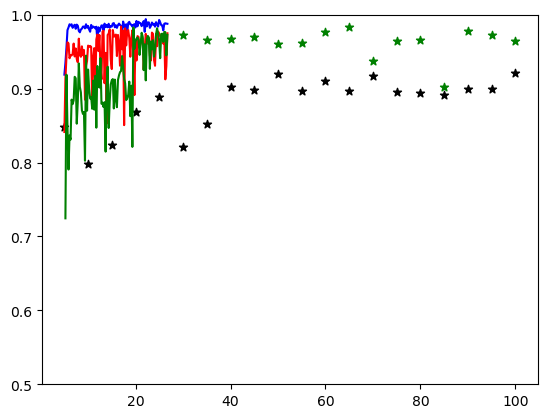

In [18]:
import matplotlib.pyplot as plt
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  first_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  second_log] , color = "red" )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(1,101)], [ x[1] for x in  third_log] , color = "green" )
# plt.axhline(0.94)
# plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )
plt.scatter(train_fractions*100,  [0.9728, 0.9662, 0.9671, 0.9701, 0.9610, 0.9616, 0.9765, 0.9833, 0.9368, 0.9647, 0.9661, 0.9023, 0.9776, 0.9726, 0.9647] , marker = "*" , color = "green")

catx = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
catr2 = [0.8485,0.7977,0.8232,0.8679,0.8881,0.8207,0.8525,0.9018,0.8979,0.9201,0.8962,0.9099,0.8961,0.9166,0.8959,0.8942,0.8908,0.8992,0.8988,0.9215]
plt.scatter([x* 100 for x in catx] , catr2, marker = "*", color = "black")
plt.ylim(0.5,1)

# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864


(0.8, 1.0)

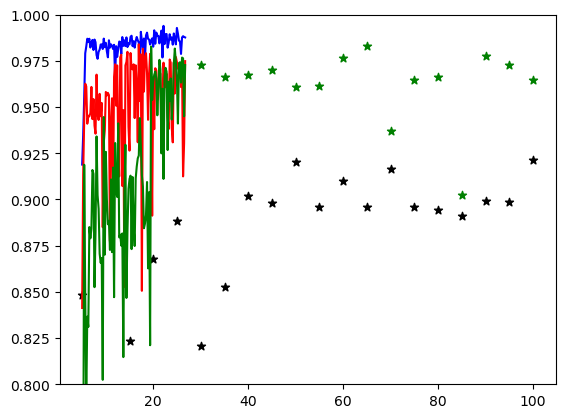

In [17]:
import matplotlib.pyplot as plt
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  first_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  second_log] , color = "red" )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(1,101)], [ x[1] for x in  third_log] , color = "green" )
# plt.axhline(0.94)
# plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )
plt.scatter(train_fractions*100,  [0.9728, 0.9662, 0.9671, 0.9701, 0.9610, 0.9616, 0.9765, 0.9833, 0.9368, 0.9647, 0.9661, 0.9023, 0.9776, 0.9726, 0.9647] , marker = "*" , color = "green")

catx = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
catr2 = [0.8485,0.7977,0.8232,0.8679,0.8881,0.8207,0.8525,0.9018,0.8979,0.9201,0.8962,0.9099,0.8961,0.9166,0.8959,0.8942,0.8908,0.8992,0.8988,0.9215]
plt.scatter([x* 100 for x in catx] , catr2, marker = "*", color = "black")
plt.ylim(0.8,1)

# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864


* 확대

(0.8, 1.0)

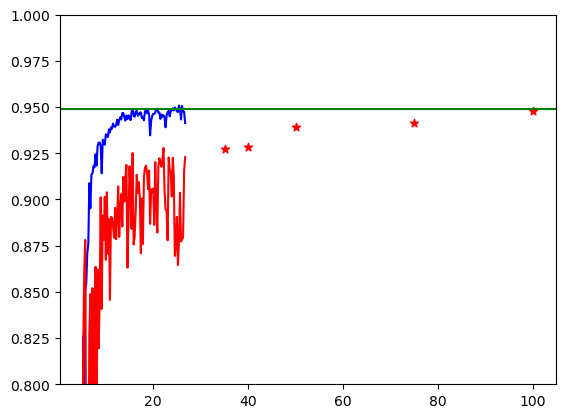

In [109]:
plt.plot([ (10* x + int(len(X_train_scaled) * 0.05)) * 100/ len(X_train_scaled) for x in range(0,101)], [ x[1] for x in  first_performance_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train_scaled) * 0.05)) * 100/ len(X_train_scaled) for x in range(0,101)], [ x[1] for x in  second_performance_log] , color = "red" )
# plt.axhline(0.94)
plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )

plt.axhline(y  =max( [ x[1] for x in  first_performance_log]) - 0.002, color = 'green')
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864
plt.ylim(0.80, 1)